### Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_yearly

### Data

In [2]:
# 데이터셋 기본 정보
train = pd.read_csv('/Users/haylee/Desktop/Desktop/LG_Aimers/해커톤/open/train.csv')
print(train.shape)
print(train.info())
print(train.tail())

(15890, 465)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15890 entries, 0 to 15889
Columns: 465 entries, ID to 2023-04-04
dtypes: int64(460), object(5)
memory usage: 56.4+ MB
None
          ID                제품             대분류             중분류  \
15885  15885  B002-03799-00002  B002-C001-0003  B002-C002-0008   
15886  15886  B002-03799-00003  B002-C001-0003  B002-C002-0008   
15887  15887  B002-03799-00004  B002-C001-0003  B002-C002-0008   
15888  15888  B002-03799-00005  B002-C001-0003  B002-C002-0008   
15889  15889  B002-03799-00010  B002-C001-0002  B002-C002-0004   

                  소분류         브랜드  2022-01-01  2022-01-02  2022-01-03  \
15885  B002-C003-0042  B002-03799           0           0           0   
15886  B002-C003-0044  B002-03799           0           0           0   
15887  B002-C003-0044  B002-03799           0           0           0   
15888  B002-C003-0044  B002-03799           0           0           0   
15889  B002-C003-0020  B002-03799           0       

In [3]:
# 데이터셋 날짜 컬럼 melt
train_m = train.melt(id_vars=['ID', '제품', '대분류', '중분류', '소분류', '브랜드'],
                var_name='ds', value_name='y', ignore_index=True)
# 데이터프레임에서 필요한 컬럼만 가져오기
train_s = train_m.loc[train_m['ID'] == 1].loc[:, ['ds', 'y']]
train_s.head()

,ds,y
1,2022-01-01,0
15891,2022-01-02,0
31781,2022-01-03,0
47671,2022-01-04,0
63561,2022-01-05,0


### model_sample

In [ ]:
m = Prophet() # ID=1에 대한 prophet 오브젝트 생성
m.fit(train_s) # 과거 1년간의 데이터 fit

In [ ]:
# 예측할 dataframe 생성하기, 이후 115일 예측 (23.04.04까지는 데이터 있음)
future = m.make_future_dataframe(periods=115)
future.tail()

In [ ]:
# 실제 예측 및 결과값 확인 -> predict 메소드 사용
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
# Forecasting Growth
# cap이 상한값, floor은 하한값

train_s['cap'] = 8
train_s['floor'] = 0


# Trend ChangePoints -> 트렌드가 변경하는 지점을 자동으로 감지하여 트렌드를 예측
# Adjusting trend flexibility 유연성 조정
# 유연성이 심하거나(overfit) 충분하지 않은 경우(underfit)
# 0.05 default, 값을 늘리면 underfit 해결, 값을 줄이면 overfit 해결
m = Prophet(growth='logistic', changepoint_range=0.9, changepoint_prior_scale=0.5)
m.fit(train_s)

future = m.make_future_dataframe(periods=115)
future['cap'] = 8
future['floor'] = 0

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
fig = m.plot(forecast)
add_changepoints_to_plot(fig.gca(), m, forecast)
plt.xticks(rotation=90)
plt.show()

### feature 추가

In [4]:
# Modeling Holidays and Special Events
# dataframe 만들어 줄 때 과거와 미래 데이터가 모두 포함 되어야 함
# 해당일 주변의 날짜를 포함 시키기 위해 lower_window, upper_window 설정

nationalHolidays = pd.DataFrame({
  'holiday': 'nationalHolidays',
  'ds': pd.to_datetime(['2022-01-01','2022-01-31','2022-02-01','2022-02-01',
                        '2022-03-01','2022-03-09','2022-05-05','2022-06-01',
                        '2022-06-06','2022-08-15','2022-09-09','2022-09-10',
                        '2022-09-11','2022-09-12','2022-10-03','2022-10-10']),
})

eventdays = pd.DataFrame({
  'holiday': 'eventdays',
  'ds': pd.to_datetime(['2022-07-10','2022-07-18','2022-07-26',
                        '2022-08-16','2022-08-22','2022-08-30',
                        '2022-11-06']),
  'lower_window': -5,
  'upper_window': 5
})

holidays = pd.concat((nationalHolidays, eventdays))

In [5]:
holidays.fillna(0)

,holiday,ds,lower_window,upper_window
0,nationalHolidays,2022-01-01,0.0,0.0
1,nationalHolidays,2022-01-31,0.0,0.0
2,nationalHolidays,2022-02-01,0.0,0.0
3,nationalHolidays,2022-02-01,0.0,0.0
4,nationalHolidays,2022-03-01,0.0,0.0
5,nationalHolidays,2022-03-09,0.0,0.0
6,nationalHolidays,2022-05-05,0.0,0.0
7,nationalHolidays,2022-06-01,0.0,0.0
8,nationalHolidays,2022-06-06,0.0,0.0
9,nationalHolidays,2022-08-15,0.0,0.0


In [6]:
m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            changepoint_range=0.9, changepoint_prior_scale=0.5)
m.fit(train_s)

15:55:18 - cmdstanpy - INFO - Chain [1] start processing
15:55:18 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
future = m.make_future_dataframe(periods=21)
future.tail()

,ds
475,2023-04-21
476,2023-04-22
477,2023-04-23
478,2023-04-24
479,2023-04-25


In [8]:
# 실제 예측 및 결과값 확인 -> predict 메소드 사용
forecast = m.predict(future)
forecast.yhat = np.where(forecast.yhat < 0, 0, forecast.yhat)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,0.000000,-1.650141,1.011960
1,2022-01-02,0.000000,-1.672581,1.010287
2,2022-01-03,0.000000,-1.739606,0.958040
3,2022-01-04,0.000000,-1.818043,0.926802
4,2022-01-05,0.000000,-1.704204,1.046094
...,...,...,...,...
475,2023-04-21,0.360808,-1.078570,1.726565
476,2023-04-22,0.185566,-1.189989,1.467988
477,2023-04-23,0.000000,-1.346755,1.382864
478,2023-04-24,0.000000,-1.507474,1.184951


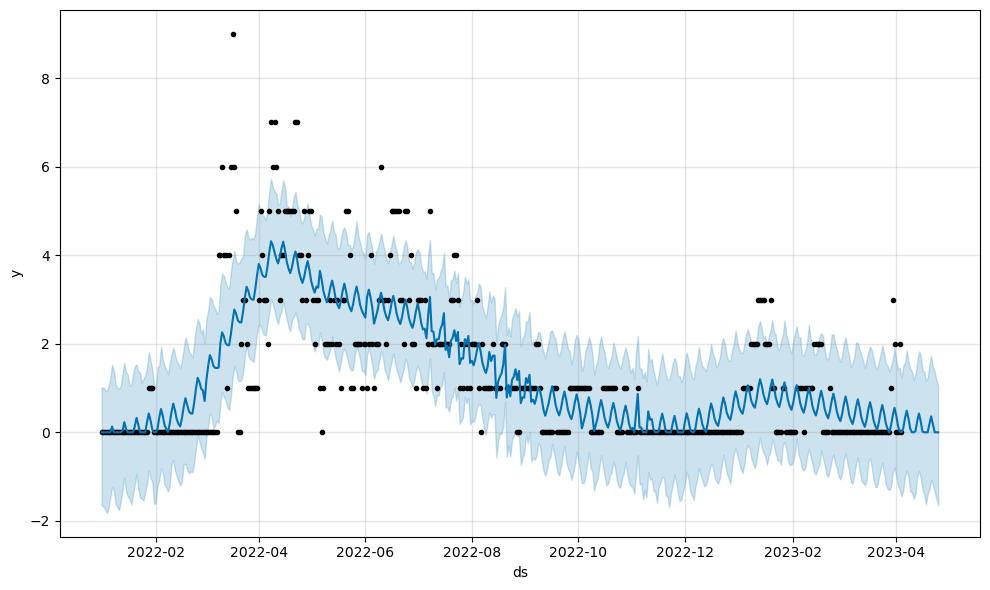

In [9]:
fig1 = m.plot(forecast)

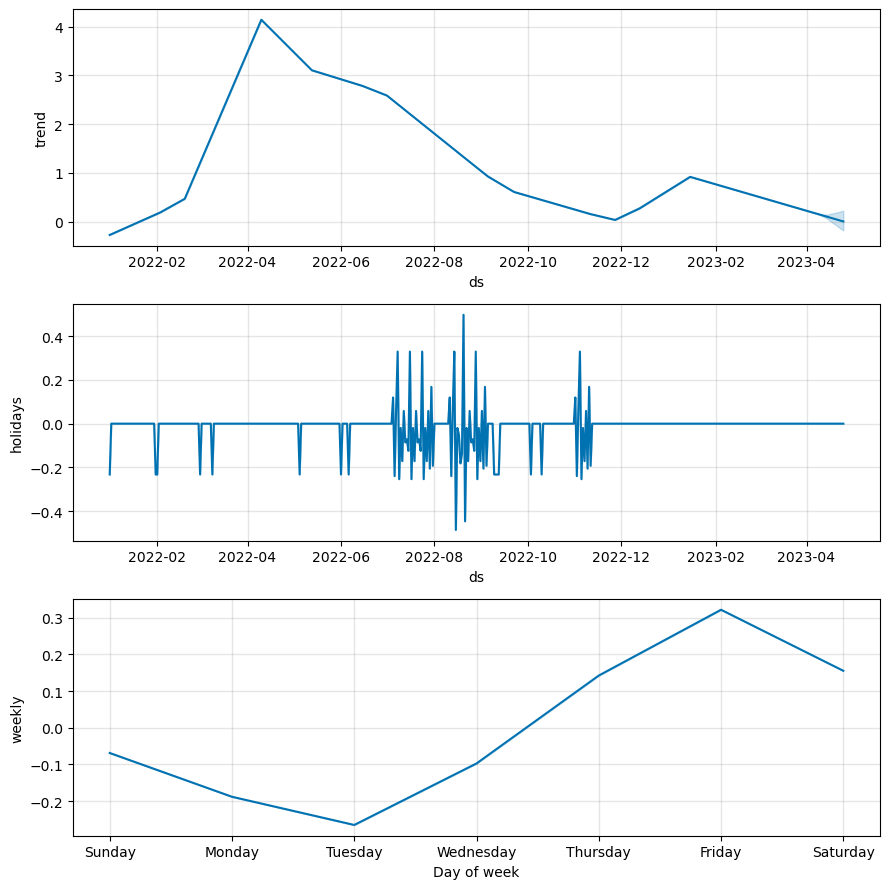

In [10]:
fig2 = m.plot_components(forecast)

In [11]:
# 각 holidays피쳐가 주는 영향 확인 -> 최근 날짜부터 10개 컬럼을 출력
forecast[(forecast['nationalHolidays'] + 
          forecast['eventdays']).abs() > 0][['ds', 'nationalHolidays', 'eventdays']][-10:]

,ds,nationalHolidays,eventdays
305,2022-11-02,0.0,-0.239532
306,2022-11-03,0.0,0.068313
307,2022-11-04,0.0,0.329322
308,2022-11-05,0.0,-0.253551
309,2022-11-06,0.0,-0.019632
310,2022-11-07,0.0,-0.171218
311,2022-11-08,0.0,0.058134
312,2022-11-09,0.0,-0.205321
313,2022-11-10,0.0,0.168128
314,2022-11-11,0.0,-0.192483


15:55:52 - cmdstanpy - INFO - Chain [1] start processing
15:55:52 - cmdstanpy - INFO - Chain [1] done processing


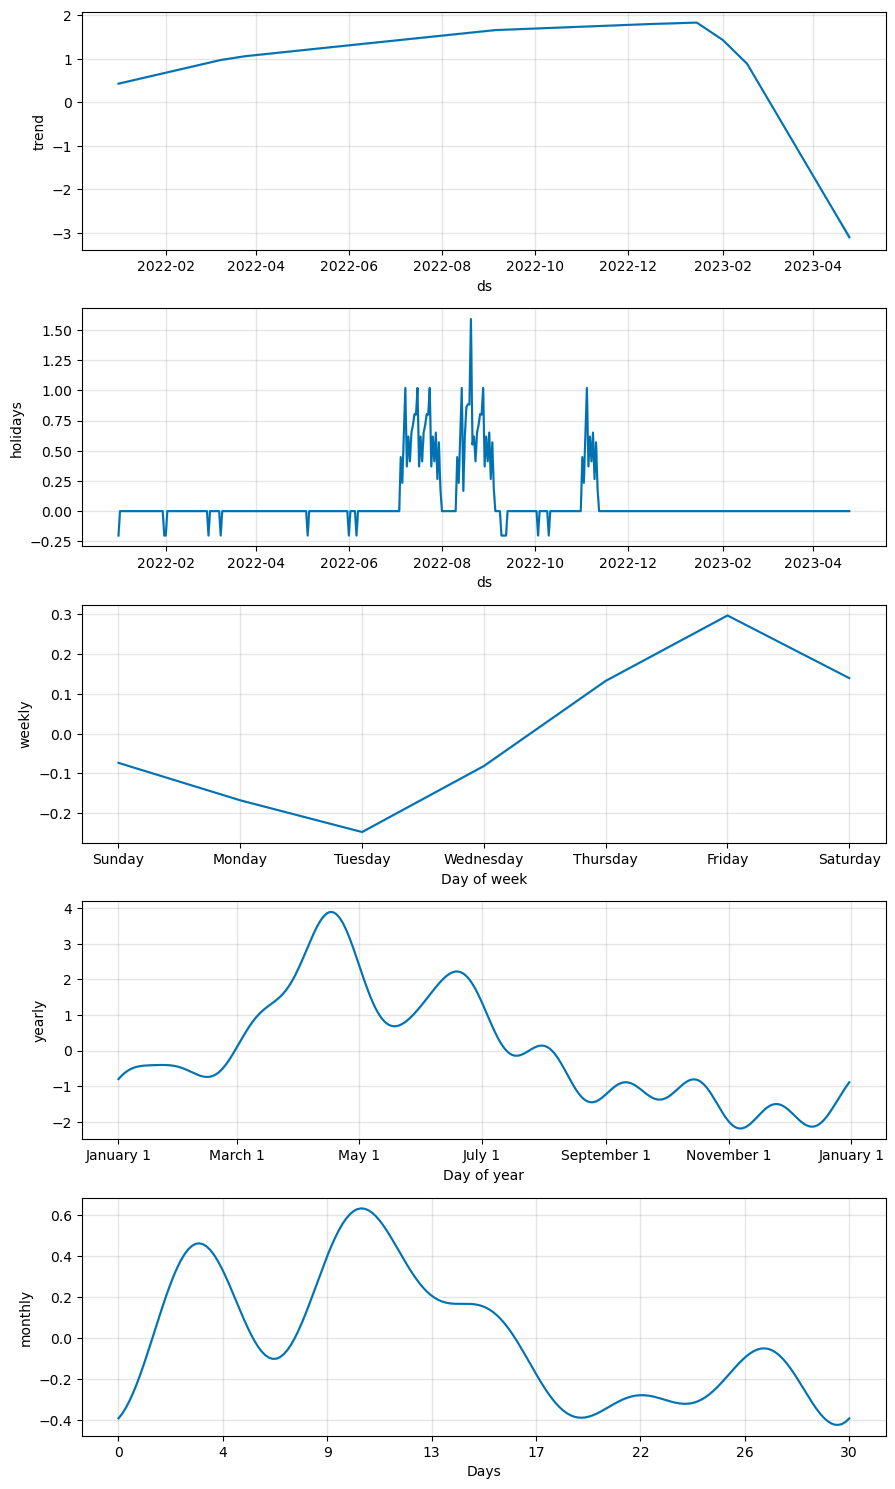

In [13]:
# prophet에서 기본적으로 weekly, yearly 특성 제공
# 그 외에 add_seasonality 함수를 활용해 특성 추가 가능
m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            changepoint_range=0.9, changepoint_prior_scale=0.5)
m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10, mode='additive')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=10, mode='additive')
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10, mode='additive')
forecast = m.fit(train_s).predict(future)
fig = m.plot_components(forecast)

In [14]:
# Additional regressors -> 모델의 선형적으로 예측값을 증가
# add_regressor : 1, 0와 같이 binary일 필요가 없이, 연속 숫자를 넣는 것이 가능
# weekday -> 월요일=0, 일요일=6 : 창립행사기간의 일요일에는 추가 효과를 더할 수 있다
def inaugural_sunday(ds):
    date = pd.to_datetime(ds)
    if date.weekday() == 6 and (date.month == 7):
        return 1
    else:
        return 0

train_s['inaugural_sunday'] = train_s['ds'].apply(inaugural_sunday)

In [15]:
train_s

,ds,y,inaugural_sunday
1,2022-01-01,0,0
15891,2022-01-02,0,0
31781,2022-01-03,0,0
47671,2022-01-04,0,0
63561,2022-01-05,0,0
...,...,...,...
7214061,2023-03-31,2,0
7229951,2023-04-01,0,0
7245841,2023-04-02,0,0
7261731,2023-04-03,2,0


In [18]:
# prophet에서 기본적으로 weekly, yearly 특성 제공
# 그 외에 add_seasonality 함수를 활용해 특성 추가 가능
m = Prophet(holidays=holidays, holidays_prior_scale=0.5,
            changepoint_range=0.9, changepoint_prior_scale=0.5)
m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10, mode='additive')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=10, mode='additive')
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10, mode='additive')
m.add_regressor('inaugural_sunday')


15:57:24 - cmdstanpy - INFO - Chain [1] start processing
15:57:24 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,eventdays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-01,0.332973,-1.677867,0.675393,0.332973,0.332973,-0.876029,-0.876029,-0.876029,0.0,...,0.139218,0.139218,0.139218,-0.750044,-0.750044,-0.750044,0.0,0.0,0.0,-0.543056
1,2022-01-02,0.342067,-1.619518,0.718858,0.342067,0.342067,-0.829270,-0.829270,-0.829270,0.0,...,-0.071011,-0.071011,-0.071011,-0.683094,-0.683094,-0.683094,0.0,0.0,0.0,-0.487203
2,2022-01-03,0.351161,-1.860693,0.454925,0.351161,0.351161,-1.019421,-1.019421,-1.019421,0.0,...,-0.168196,-0.168196,-0.168196,-0.622736,-0.622736,-0.622736,0.0,0.0,0.0,-0.668260
3,2022-01-04,0.360255,-2.017069,0.288720,0.360255,0.360255,-1.211348,-1.211348,-1.211348,0.0,...,-0.247790,-0.247790,-0.247790,-0.569101,-0.569101,-0.569101,0.0,0.0,0.0,-0.851093
4,2022-01-05,0.369349,-1.837721,0.555320,0.369349,0.369349,-0.994116,-0.994116,-0.994116,0.0,...,-0.081469,-0.081469,-0.081469,-0.522159,-0.522159,-0.522159,0.0,0.0,0.0,-0.624767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2023-04-21,-2.795690,0.299255,2.653927,-2.827373,-2.765742,4.229656,4.229656,4.229656,0.0,...,0.296513,0.296513,0.296513,3.754815,3.754815,3.754815,0.0,0.0,0.0,1.433966
476,2023-04-22,-2.852996,-0.039840,2.261797,-2.887897,-2.819746,3.986189,3.986189,3.986189,0.0,...,0.139218,0.139218,0.139218,3.680045,3.680045,3.680045,0.0,0.0,0.0,1.133193
477,2023-04-23,-2.910302,-0.365801,1.888595,-2.948975,-2.874010,3.655418,3.655418,3.655418,0.0,...,-0.071011,-0.071011,-0.071011,3.588511,3.588511,3.588511,0.0,0.0,0.0,0.745115
478,2023-04-24,-2.967608,-0.863702,1.576843,-3.010171,-2.927459,3.322706,3.322706,3.322706,0.0,...,-0.168196,-0.168196,-0.168196,3.481390,3.481390,3.481390,0.0,0.0,0.0,0.355098


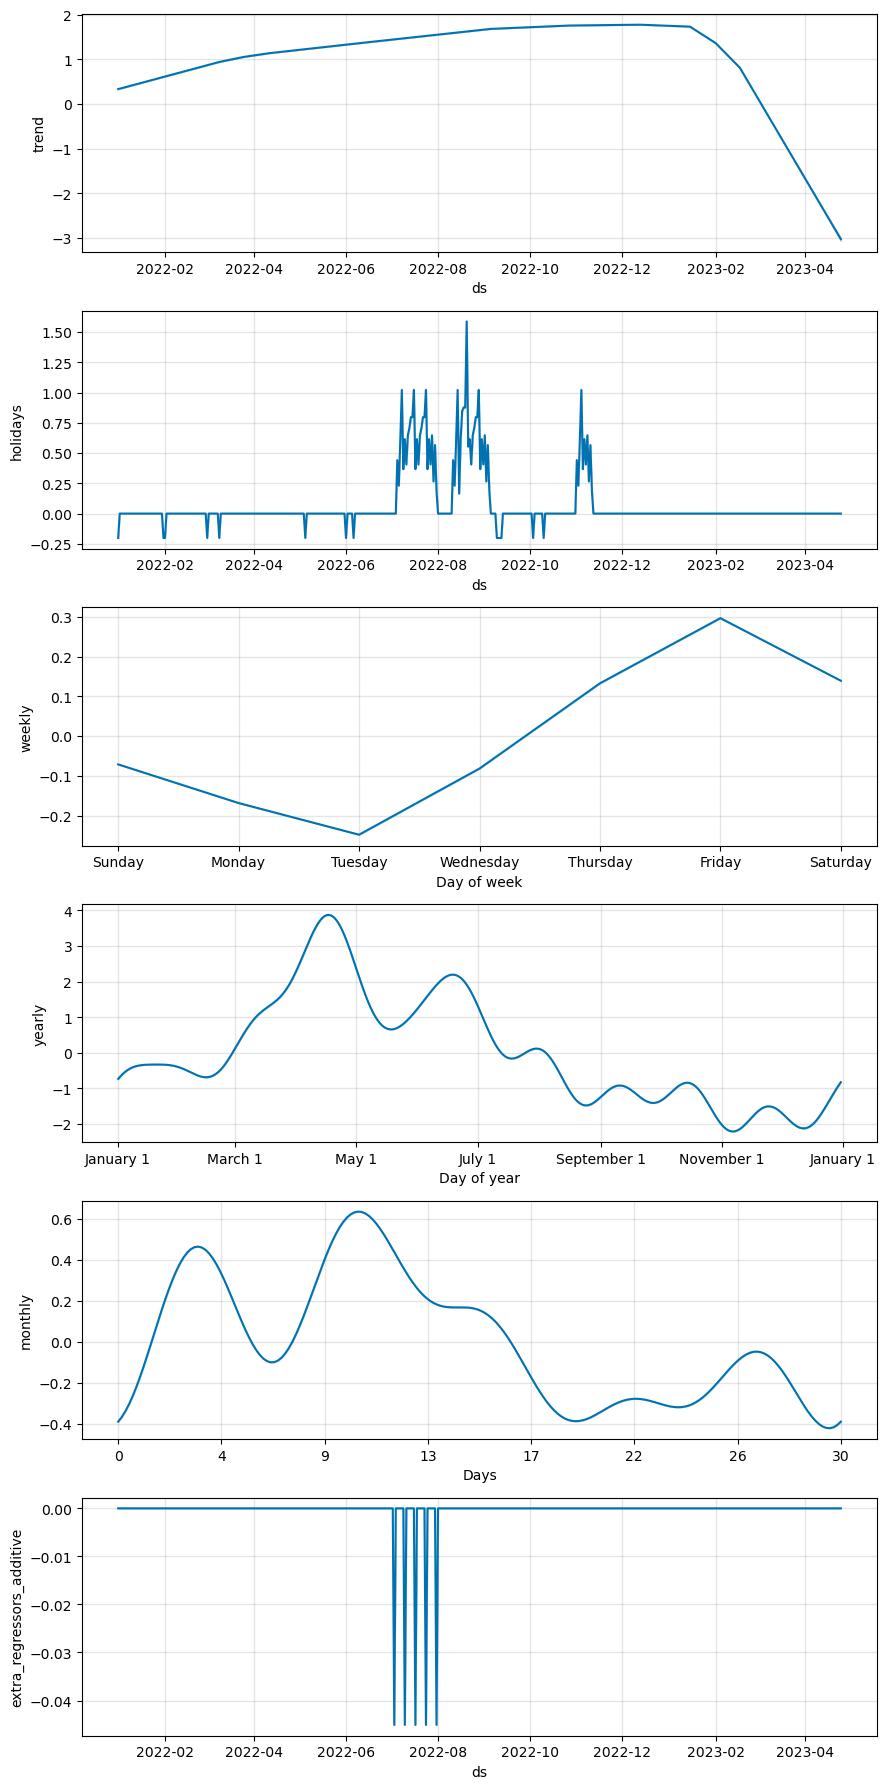

In [19]:
future['inaugural_sunday'] = future['ds'].apply(inaugural_sunday)
forecast = m.fit(train_s).predict(future)
fig = m.plot_components(forecast)
forecast

In [ ]:
# 과거 데이터 학습 추가하면 사용해 볼만 함
'''
m = Prophet(seasonality_mode='multiplicative')
fig = m.plot_components(forecast)
'''

15:57:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status





chain 1 |████      | 00:00 Iteration:   1 / 300 [  0%]  (Warmup)
chain 1 |██████    | 00:01 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:01 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 250 / 300 [ 83%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


15:57:36 - cmdstanpy - INFO - CmdStan done processing.
15:57:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-310/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-310/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_359nec7q0r/croot/prophet_1689928107726/work/build/lib.macosx-11.1-arm64-cpython-310/prophet/stan_model/prophet

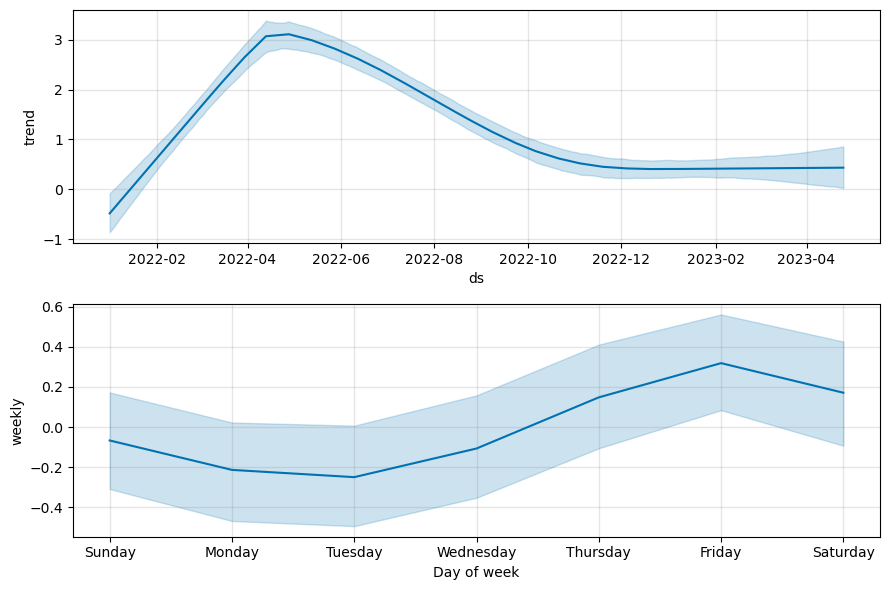

In [20]:
# Uncertainty Intervals 불확실성의 범위 -> 큰 영향은 없어 보임
# prophet의 yhat은 예측 정확도, 신뢰구간의 조정 기본값 80% -> 95%로 조정
# 계절성의 신뢰구간을 구하기 위해 몇 개의 샘플을 사용하겠느냐 -> 데이터의 최초 300일에 대해 적용
m = Prophet(interval_width=0.95, mcmc_samples=300).fit(train_s)
forecast = m.predict(future)
fig = m.plot_components(forecast)

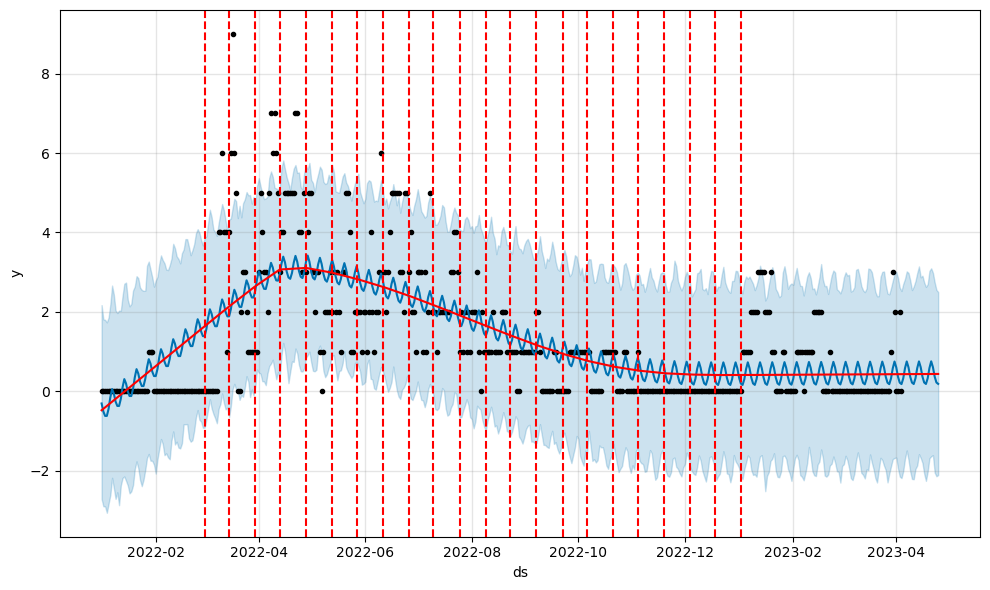

In [21]:
fig3 = m.plot(forecast)
a = add_changepoints_to_plot(fig3.gca(), m, forecast)